In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time

In [2]:
def plot(x, y, name="AM7"):
    plt.figure(figsize=(20,5))
    plt.title(name, fontsize=16)
    plt.xlabel('time')
    plt.ylabel('voltage')
    plt.plot(x, y, 'y')
    plt.legend(['voltage'], fontsize=8)
    plt.show()

def plot_compare(x, y, xd, yd, unit, name="AM7"):
    plt.figure(figsize=(20,5))
    plt.title(name, fontsize=16)
    plt.xlabel('time')
    plt.plot(xd, yd, 'r--')
    plt.plot(x, y, 'y:')
    plt.legend([unit, "voltage"], fontsize=8)
    plt.show()

plt.style.use('dark_background')

In [3]:
def get_chord(name):
    npz = np.load(f"data/raw/{name}.npz")
    return npz['arr_0'], npz['arr_1']

In [ ]:
import os

def dig(path, ftype):
    # returns list of all files of the specified extension in every recursive subdirectory in a given parent dir
    paths = []
    for dirpath, _, files in os.walk(path):
        paths += [(dirpath + "/" + f) for f in files if f.endswith(ftype)]
    return paths

for file in os.listdir("./data/raw/"):
    if file.endswith(".npz"):
        data = np.load(f"data/raw/{file}")
        volt = data['arr_1']
        time = data['arr_0']
        plot(time[1000:13000], volt[1000:13000], name=file[:-4])

### Experimenting with different data transformations

In [4]:
from scipy.signal import stft, savgol_filter, spectrogram, istft
from scipy.stats import skew, kurtosis

#### Savitsky-Golay filter

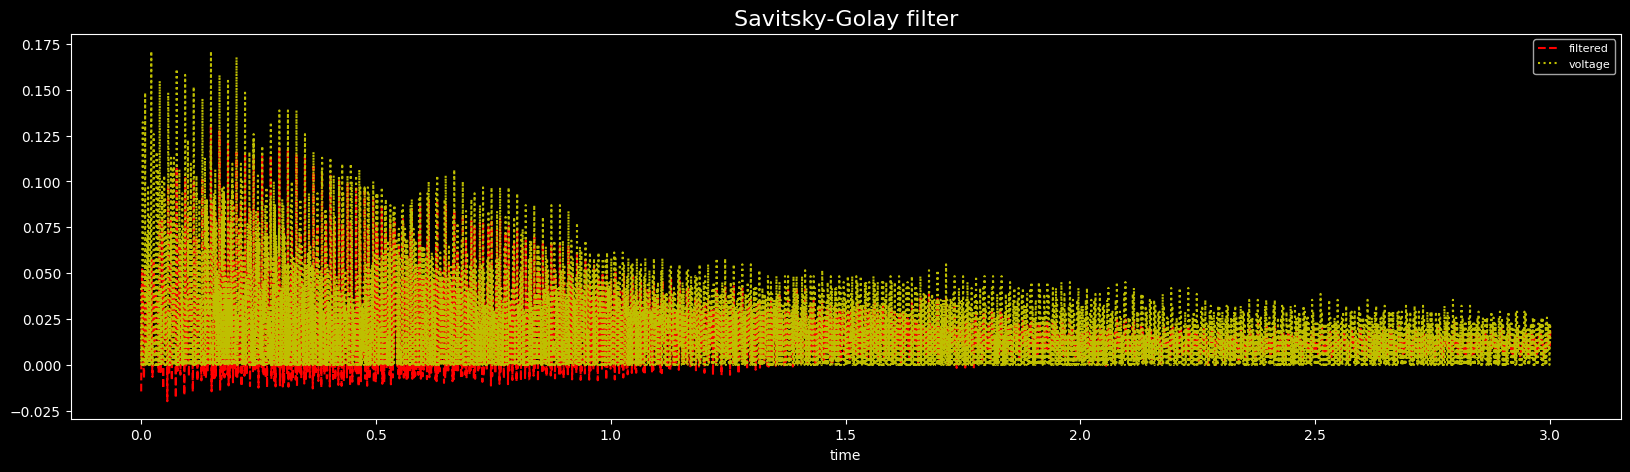

In [5]:
time, data = get_chord("AM53")
plot_compare(time, data, time, savgol_filter(data, window_length=30, polyorder=4), "filtered", "Savitsky-Golay filter")

#### Fourier tranasform

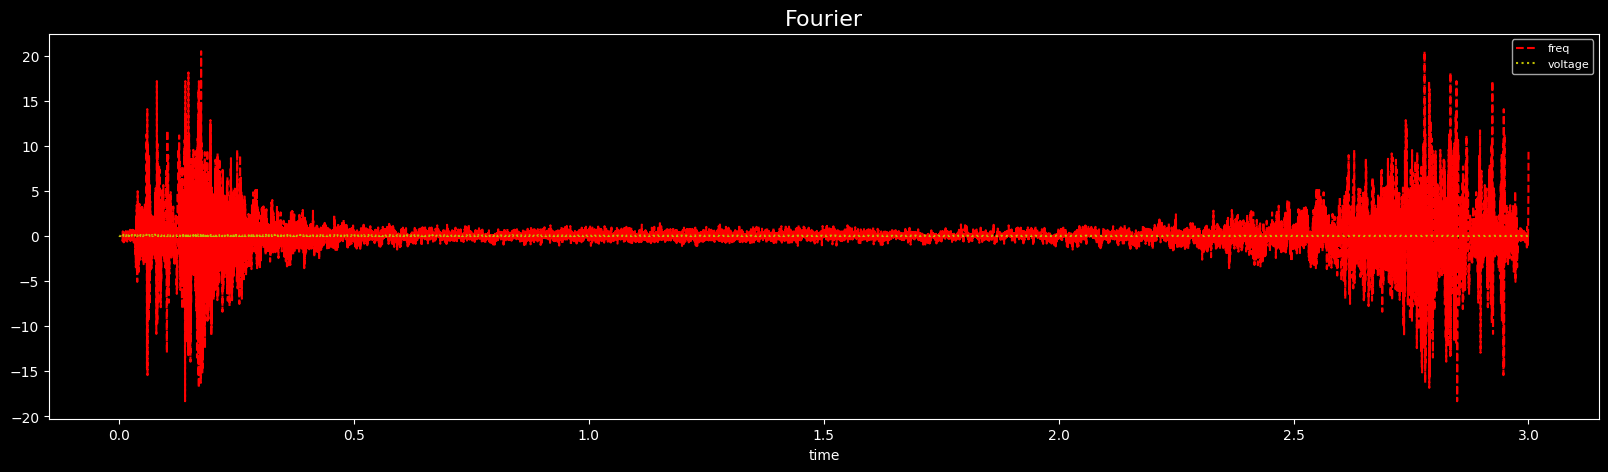

In [12]:
plot_compare(time, data, time[20:], np.fft.fft(data)[20:], "freq", "Fourier")

#### Short-time fourier transform / Spectrogram

In [7]:
def plot_stft(t, f, Zxx, name):
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', vmin=0, vmax=0.0175)
    plt.title(name)
    plt.ylabel('Hz')
    plt.xlabel('sec')
    plt.colorbar(label='Magnitude')
    plt.ylim(0, 3000)
    plt.show()

def plot_spectro(t, f, Sxx, name):
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis', vmin=-130, vmax=-60)
    plt.title(name)
    plt.ylabel('Hz')
    plt.xlabel('sec')
    plt.colorbar(label='Intensity (dB)')
    plt.ylim(0, 3000)
    plt.show()

51 384 (51, 384)


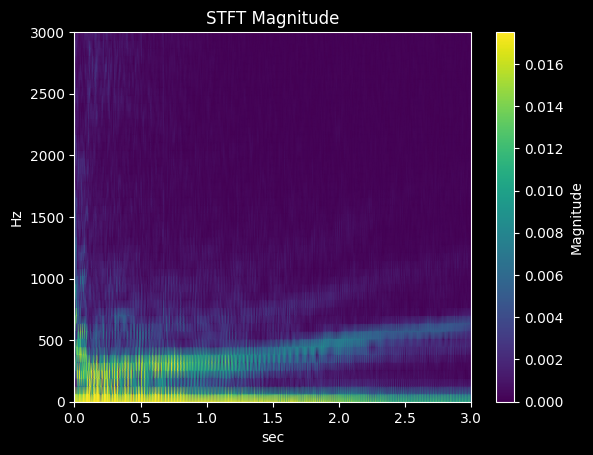

129 85 (129, 85)
[   0.           24.92578125   49.8515625    74.77734375   99.703125
  124.62890625  149.5546875   174.48046875  199.40625     224.33203125
  249.2578125   274.18359375  299.109375    324.03515625  348.9609375
  373.88671875  398.8125      423.73828125  448.6640625   473.58984375
  498.515625    523.44140625  548.3671875   573.29296875  598.21875
  623.14453125  648.0703125   672.99609375  697.921875    722.84765625
  747.7734375   772.69921875  797.625       822.55078125  847.4765625
  872.40234375  897.328125    922.25390625  947.1796875   972.10546875
  997.03125    1021.95703125 1046.8828125  1071.80859375 1096.734375
 1121.66015625 1146.5859375  1171.51171875 1196.4375     1221.36328125
 1246.2890625  1271.21484375 1296.140625   1321.06640625 1345.9921875
 1370.91796875 1395.84375    1420.76953125 1445.6953125  1470.62109375
 1495.546875   1520.47265625 1545.3984375  1570.32421875 1595.25
 1620.17578125 1645.1015625  1670.02734375 1694.953125   1719.87890625
 1744

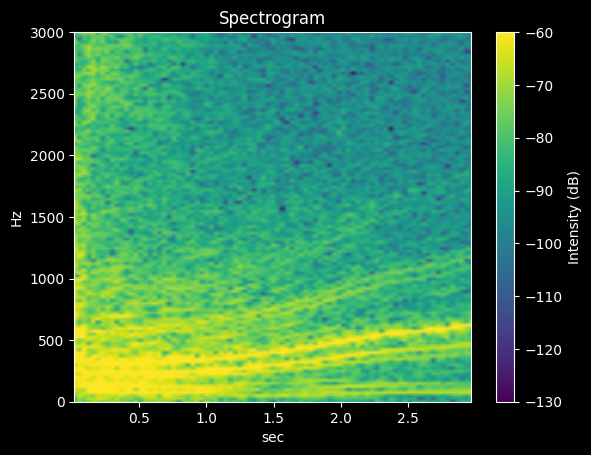

In [9]:
# fs = sampling frequency = 18742 samples / 3 sec
# nperseg = window length: 64 - 2048
# noverlap = overlap length: < nperseg
f, t, Zxx = stft(data, fs=len(data) // 3, nperseg=100, noverlap=50)
print(len(f), len(t), Zxx.shape)

plot_stft(t, f, Zxx, "STFT Magnitude")

f, t, Sxx = spectrogram(data, fs=len(data) // 3)
print(len(f), len(t), Sxx.shape)
print(f)
plot_spectro(t, f, Sxx, "Spectrogram")

### Save all data as spectrogram pngs

In [6]:
def saveplt(name, dir, style):
    _, chord = get_chord(name)
    freq = len(chord) // 3
    if style == "spectro":
        f, t, Sxx = spectrogram(chord[1000:13000], fs=freq)
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis', vmin=-130, vmax=-60)
    elif style == "stft":
        f, t, Zxx = stft(chord, fs=freq, nperseg=100, noverlap=50)
        plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', vmin=0, vmax=0.0175)
    plt.axis('off')
    plt.margins(0, 0)
    plt.tight_layout(pad=0)
    plt.savefig(f'./data/{dir}/{name}.png', bbox_inches='tight', pad_inches=0)
    plt.clf()

In [9]:
for file in os.listdir("./data/raw/"):
    if file.endswith(".npz"):
        saveplt(file[:-4], "raw", "spectro")

<Figure size 640x480 with 0 Axes>

#### Check all spectrograms

In [83]:
for file in os.listdir("./data/raw/"):
    if file.endswith(".png"):
        img = cv2.imread(f"./data/raw/{file}")
        cv2.imshow("image", img)
        cv2.waitKey(0)

### Chord type comparison

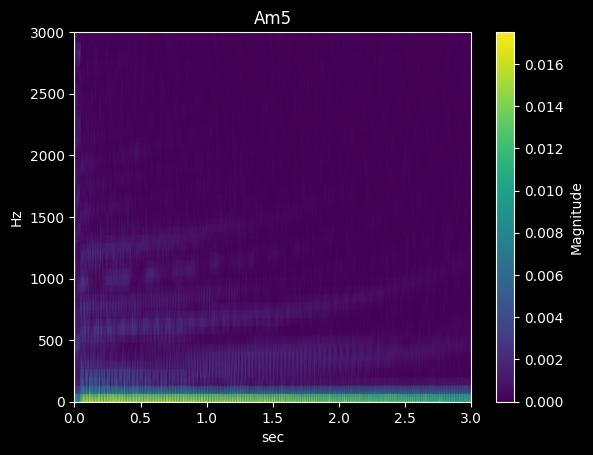

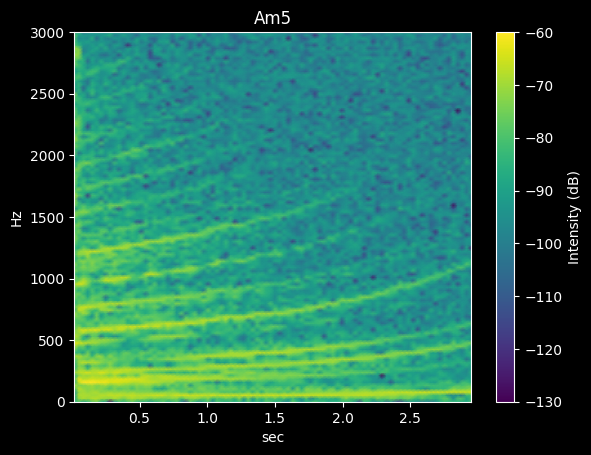

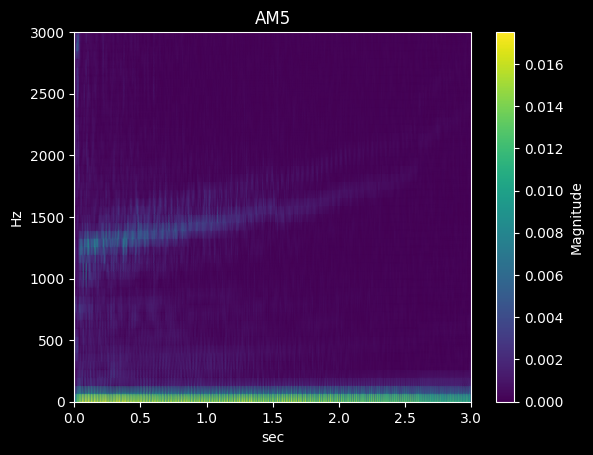

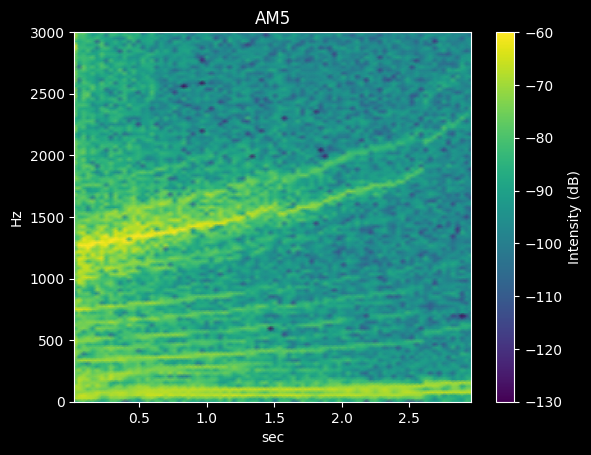

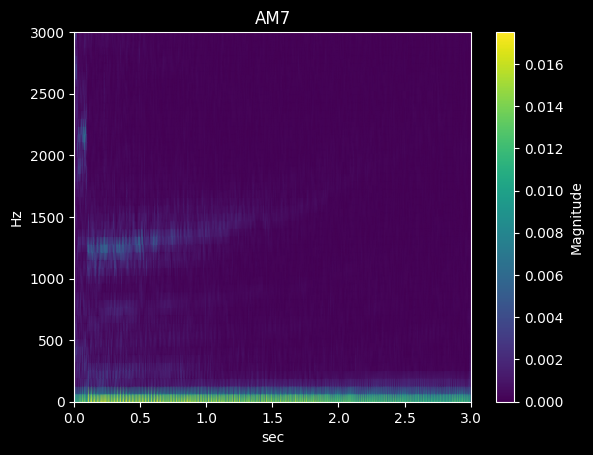

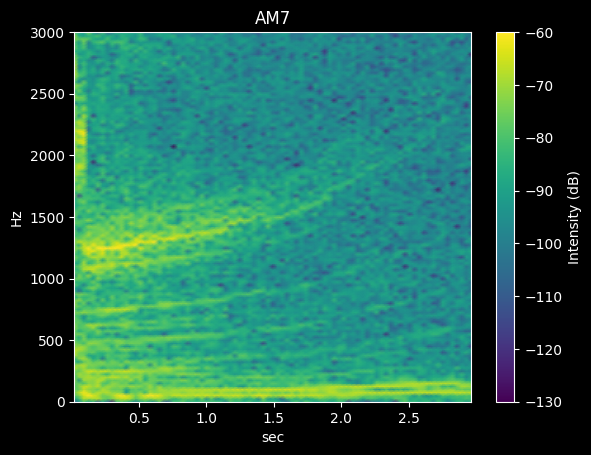

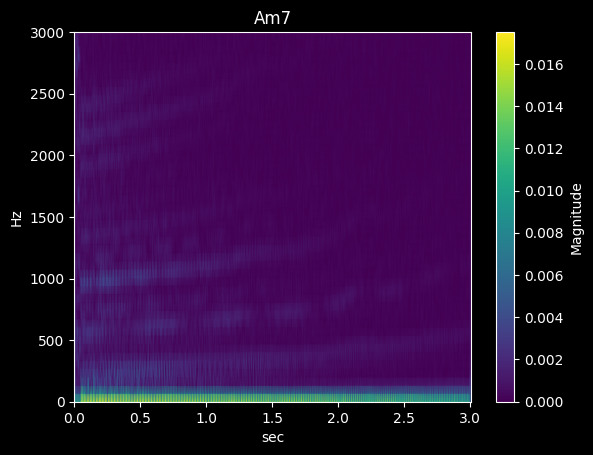

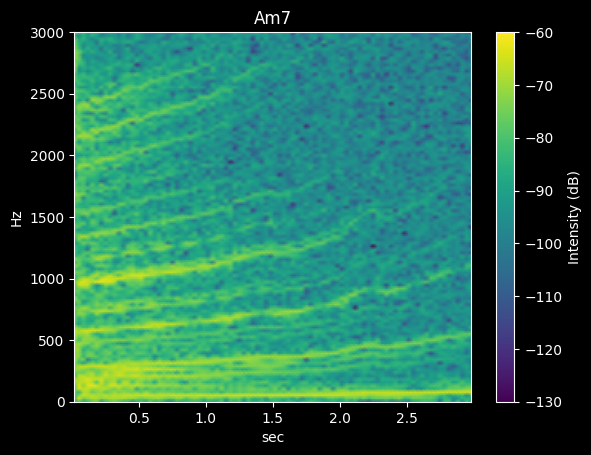

In [23]:
def chord_plot(name):
    _, chord = get_chord(name)
    freq = len(chord) // 3.0
    fz, tz, Zxx = stft(chord, fs=freq, nperseg=100, noverlap=50)
    plot_stft(tz, fz, Zxx, name)
    fs, ts, Sxx = spectrogram(chord, fs=freq)
    plot_spectro(ts, fs, Sxx, name)

chord_plot("Am5")
chord_plot("AM5")
chord_plot("AM7")
chord_plot("Am7")

In [ ]:
mean = np.mean(data)
variance = np.var(data)
skewness = skew(data)
kurtosis_ = kurtosis(data)
mean, variance, skewness, kurtosis_

#### Experimentation with audio reconstructions

In [ ]:
import pyaudio

time, data = get_chord("AM7")
time, data
rate = len(data) // 3
f, t, Sxx = spectrogram(data, fs=rate // 3)
_, audio = istft(spectrogram, fs=rate // 3, nperseg=1000, noverlap=500)

p = pyaudio.PyAudio()

stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=44100,
                output=True)

# Convert the audio data to bytes
audio_bytes = (audio * 32767).astype(np.int16).tobytes()

stream.write(audio_bytes)
stream.stop_stream()
stream.close()